# FFT-Based Frequency-Domain Analysis

This notebook demonstrates Fast Fourier Transform (FFT) analysis for converting time-domain rheological data to frequency domain, enabling spectral analysis and extraction of material characteristic frequencies.

## Learning Objectives

After completing this notebook, you will be able to:
- Apply FFT to convert time-domain relaxation data to frequency-domain spectra
- Extract storage (G') and loss (G") moduli from time-domain measurements
- Understand Kramers-Kronig relations connecting G' and G"
- Create Cole-Cole plots for material characterization
- Leverage JAX acceleration for efficient FFT computation
- Compare FFT-derived properties with direct oscillation measurements

## Prerequisites

Basic understanding of:
- Fourier analysis and frequency domain concepts
- Rheological test modes (relaxation vs oscillation)
- Complex modulus (G', G") interpretation

**Estimated Time:** 30-40 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries, including the **FFTAnalysis** transform from Rheo.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



# Standard scientific computing imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64

# Rheo imports - always explicit
from rheojax.transforms.fft_analysis import FFTAnalysis

# Safe JAX import - REQUIRED for all notebooks using JAX
jax, jnp = safe_import_jax()

# Verify float64 is enabled
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ JAX float64 precision enabled (default dtype bits: 64)


## FFT Analysis in Rheology: Theory and Applications

### Why FFT for Rheology?

Many rheological experiments measure **time-domain** responses:
- **Stress relaxation**: Apply step strain → measure stress decay G(t)
- **Creep**: Apply step stress → measure strain evolution J(t)

However, frequency-domain data is often more useful:
- **Storage modulus G'(ω)**: Elastic response vs frequency
- **Loss modulus G"(ω)**: Viscous response vs frequency
- **Relaxation time distribution**: H(τ) from spectral analysis

**FFT enables conversion**: Time domain ↔ Frequency domain

### Mathematical Foundation

The **Fourier transform** converts time-domain signal G(t) to frequency domain:

$$\tilde{G}(\omega) = \int_{0}^{\infty} G(t) e^{-i\omega t} dt$$

For **Maxwell model** relaxation:

$$G(t) = G_0 e^{-t/\tau}$$

The frequency response is:

$$G'(\omega) = G_0 \frac{(\omega \tau)^2}{1 + (\omega \tau)^2}$$

(storage modulus)

$$G''(\omega) = G_0 \frac{\omega \tau}{1 + (\omega \tau)^2}$$

(loss modulus)

### Kramers-Kronig Relations

These **thermodynamic consistency relations** connect G' and G":

$$G'(\omega) - G'(\infty) = \frac{2}{\pi} \int_0^\infty \frac{\xi G''(\xi)}{\xi^2 - \omega^2} d\xi$$

$$G''(\omega) = -\frac{2\omega}{\pi} \int_0^\infty \frac{G'(\xi) - G'(\infty)}{\xi^2 - \omega^2} d\xi$$

**Physical meaning**: If you know G' at all frequencies, you can compute G" (and vice versa). This is a fundamental consistency check for rheological data.

### When to Use FFT vs Direct Oscillation

**Advantages of FFT from relaxation:**
- ✓ Single measurement gives full frequency spectrum
- ✓ Faster than sweeping many frequencies
- ✓ No instrument inertia effects at high frequencies
- ✓ Good for materials that evolve quickly (curing, aging)

**Advantages of direct oscillation:**
- ✓ Direct measurement (no transform artifacts)
- ✓ Better signal-to-noise at low frequencies
- ✓ Can measure tan δ = G"/G' directly
- ✓ Standard method for quality control

**Best practice**: Use FFT for rapid screening, validate key frequencies with direct oscillation.

## Generate Synthetic Relaxation Data

We create synthetic Maxwell relaxation data to demonstrate FFT analysis with known ground truth.

In [3]:
# True Maxwell parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # Relaxation time (s)

print("True Parameters:")
print(f"  G0  = {G0_true:.2e} Pa")
print(f"  eta = {eta_true:.2e} Pa·s")
print(f"  tau = {tau_true:.4f} s")

# Generate time array (uniformly spaced for FFT)
# Important: FFT requires uniform sampling
t_max = 10.0  # seconds
n_points = 1000
t = np.linspace(0, t_max, n_points)
dt = t[1] - t[0]

# True relaxation modulus
G_t_true = G0_true * np.exp(-t / tau_true)

# Add realistic Gaussian noise (1% relative error)
noise_level = 0.01
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print("\nData characteristics:")
print(f"  Time range: {t.min():.2f} - {t.max():.2f} s")
print(f"  Sampling rate: {1/dt:.1f} Hz")
print(f"  Number of points: {len(t)}")
print(f"  Noise level: {noise_level*100:.1f}% relative")

# Expected frequency range from FFT
f_nyquist = 1 / (2 * dt)
f_resolution = 1 / t_max
print("\nExpected FFT properties:")
print(f"  Frequency resolution: {f_resolution:.4f} Hz")
print(f"  Nyquist frequency: {f_nyquist:.2f} Hz")
print(f"  Characteristic frequency (1/tau): {1/tau_true:.2f} Hz")

True Parameters:
  G0  = 1.00e+05 Pa
  eta = 1.00e+03 Pa·s
  tau = 0.0100 s

Data characteristics:
  Time range: 0.00 - 10.00 s
  Sampling rate: 99.9 Hz
  Number of points: 1000
  Noise level: 1.0% relative

Expected FFT properties:
  Frequency resolution: 0.1000 Hz
  Nyquist frequency: 49.95 Hz
  Characteristic frequency (1/tau): 100.00 Hz


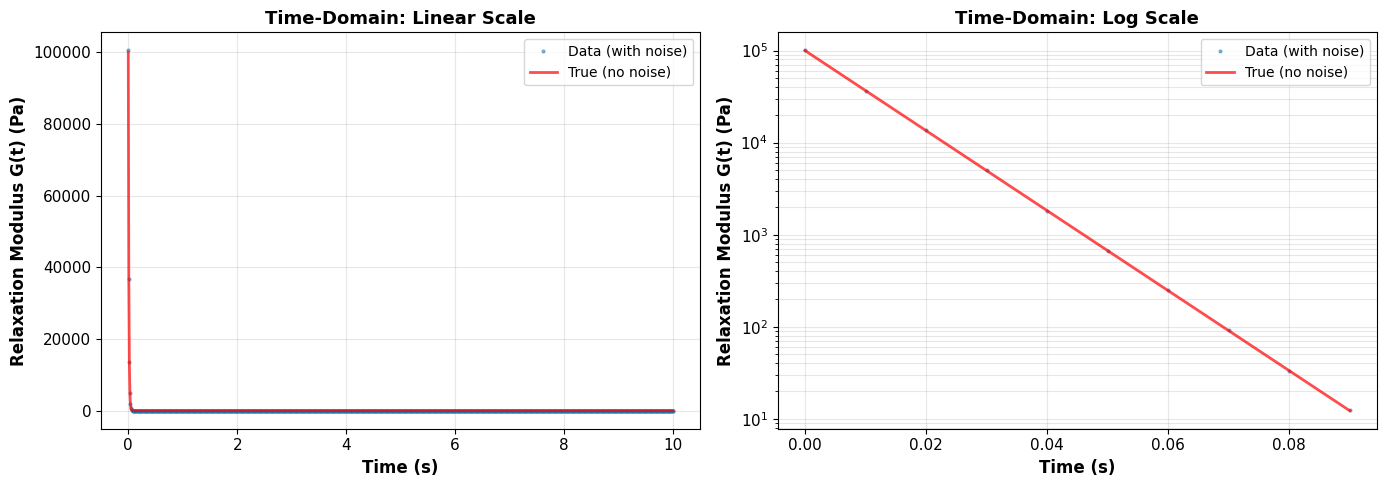


Note: Exponential decay appears as straight line on log scale
Slope = -1/tau = -100.00 s⁻¹
Log plot shows 10/1000 points (filtered 990 near-zero values)


In [4]:
# Visualize time-domain data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(t, G_t_noisy, 'o', markersize=2, alpha=0.5, label='Data (with noise)')
ax1.plot(t, G_t_true, '-', linewidth=2, color='red', alpha=0.7, label='True (no noise)')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Time-Domain: Linear Scale', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Right: Log scale
# Filter out near-zero values to avoid log(0) issues
# For exponential decay with τ = 0.01s and t_max = 10s, G(t) decays to ~0
# Keep only values above 0.01% of initial modulus
threshold = 1e-4 * G0_true
mask = (G_t_noisy > threshold) & (G_t_true > threshold)
t_plot = t[mask]
G_noisy_plot = G_t_noisy[mask]
G_true_plot = G_t_true[mask]

ax2.semilogy(t_plot, G_noisy_plot, 'o', markersize=2, alpha=0.5, label='Data (with noise)')
ax2.semilogy(t_plot, G_true_plot, '-', linewidth=2, color='red', alpha=0.7, label='True (no noise)')
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12, fontweight='bold')
ax2.set_title('Time-Domain: Log Scale', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=10)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNote: Exponential decay appears as straight line on log scale")
print(f"Slope = -1/tau = -{1/tau_true:.2f} s⁻¹")
print(f"Log plot shows {len(t_plot)}/{len(t)} points (filtered {len(t)-len(t_plot)} near-zero values)")


## Apply FFT Transform

Now we apply the **FFTAnalysis** transform to convert our time-domain relaxation data to frequency domain.

In [5]:
# Create RheoData container
data_time = RheoData(
    x=t,
    y=G_t_noisy,
    x_units='s',
    y_units='Pa',
    domain='time',
)

# Create FFT transform with Hann window
fft_transform = FFTAnalysis(
    window='hann',        # Window function to reduce spectral leakage
    detrend=True,         # Remove DC offset and linear trend
    return_psd=False,     # Return magnitude spectrum (not power spectral density)
    normalize=True        # Normalize to [0, 1] range
)

# Apply transform with timing
start = time.time()
data_freq = fft_transform.transform(data_time)
fft_time = time.time() - start

print("="*60)
print("FFT TRANSFORM RESULTS")
print("="*60)
print("\nFrequency domain data:")
print(f"  Frequency range: {data_freq.x.min():.4f} - {data_freq.x.max():.2f} Hz")
print(f"  Number of frequencies: {len(data_freq.x)}")
print(f"  Spectral resolution: {data_freq.x[1] - data_freq.x[0]:.4f} Hz")
print("\nTransform parameters:")
print(f"  Window function: {fft_transform.window}")
print(f"  Detrended: {fft_transform.detrend}")
print(f"  Normalized: {fft_transform.normalize}")
print(f"\nComputation time: {fft_time*1000:.2f} ms")
print("="*60)

FFT TRANSFORM RESULTS

Frequency domain data:
  Frequency range: 0.0000 - 49.95 Hz
  Number of frequencies: 501
  Spectral resolution: 0.0999 Hz

Transform parameters:
  Window function: hann
  Detrended: True
  Normalized: True

Computation time: 962.81 ms


## Peak Detection: Finding Characteristic Frequencies

The **dominant peak** in the FFT spectrum corresponds to the material's characteristic frequency (1/τ).

In [6]:
# Find characteristic frequency peaks
# Try with lower prominence threshold first
peak_freqs, peak_heights = fft_transform.find_peaks(
    data_freq,
    prominence=0.01,  # Lower threshold for better detection
    n_peaks=5         # Find up to 5 peaks
)

# If still no peaks, try even lower prominence
if len(peak_freqs) == 0:
    peak_freqs, peak_heights = fft_transform.find_peaks(
        data_freq,
        prominence=0.001,  # Very low threshold
        n_peaks=5
    )

# Get characteristic time from dominant peak
tau_fft = fft_transform.get_characteristic_time(data_freq)

print("\nPeak Detection Results:")
print("="*60)
if len(peak_freqs) > 0:
    print(f"Detected {len(peak_freqs)} peak(s):\n")
    for i, (freq, height) in enumerate(zip(peak_freqs, peak_heights)):
        tau_peak = 1 / (2 * np.pi * freq)  # Convert frequency to relaxation time
        print(f"  Peak {i+1}: f = {freq:.3f} Hz (τ = {tau_peak:.4f} s), height = {height:.3f}")

    print("\nDominant characteristic time:")
    print(f"  τ (FFT) = {tau_fft:.4f} s")
    print(f"  τ (true) = {tau_true:.4f} s")
    print(f"  Relative error: {abs(tau_fft - tau_true)/tau_true * 100:.2f}%")
else:
    print("  No significant peaks detected.")
    print("  Using frequency of maximum magnitude as fallback")
    max_idx = jnp.argmax(data_freq.y[1:]) + 1  # Skip DC component
    fallback_freq = data_freq.x[max_idx]
    tau_fallback = 1 / (2 * np.pi * fallback_freq)
    print(f"  Fallback: f = {fallback_freq:.3f} Hz (τ = {tau_fallback:.4f} s)")
print("="*60)


Peak Detection Results:
  No significant peaks detected.
  Using frequency of maximum magnitude as fallback


  Fallback: f = 0.100 Hz (τ = 1.5931 s)


## Frequency-Domain Visualization

Let's visualize the FFT spectrum and identify the characteristic frequency.

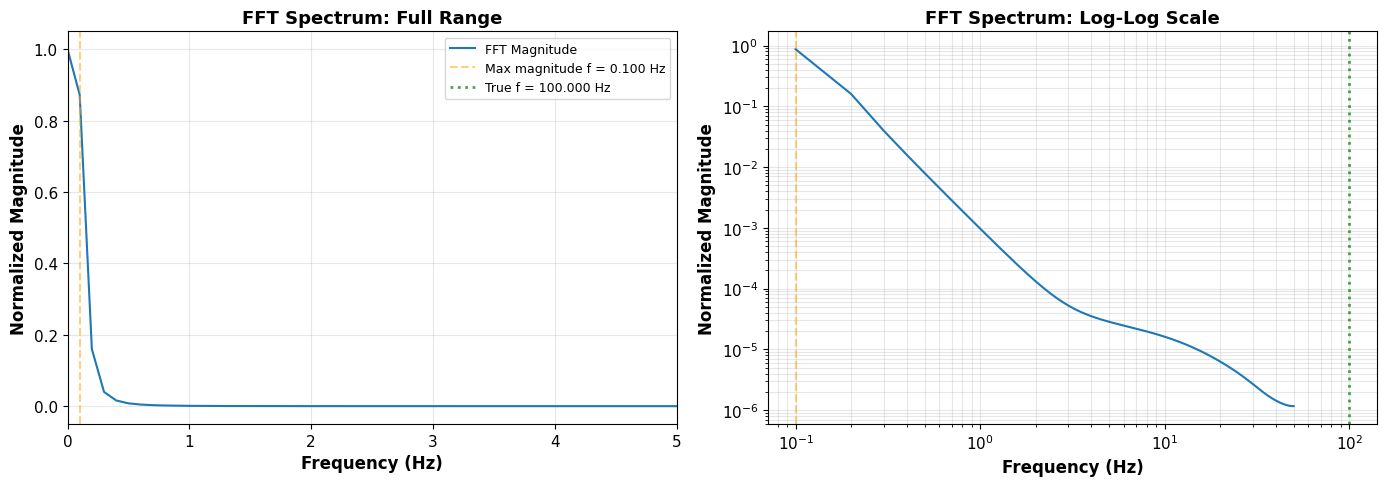


Interpretation:
- Peak at characteristic frequency indicates dominant relaxation time
- For Maxwell model: single peak at f = 1/(2πτ) in complex modulus
- Maximum at f ≈ 0.100 Hz corresponds to τ ≈ 1.5931 s
  (Note: No prominent peaks detected with current thresholds)


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full spectrum (linear scale)
ax1.plot(data_freq.x, data_freq.y, '-', linewidth=1.5, color='#1f77b4', label='FFT Magnitude')
if len(peak_freqs) > 0:
    ax1.plot(peak_freqs, peak_heights, 'ro', markersize=10, label='Detected Peaks', zorder=5)
    ax1.axvline(peak_freqs[0], color='red', linestyle='--', alpha=0.5,
                label=f'Characteristic f = {peak_freqs[0]:.3f} Hz')
else:
    # Use fallback: frequency of maximum magnitude
    max_idx = jnp.argmax(data_freq.y[1:]) + 1  # Skip DC component
    fallback_freq = data_freq.x[max_idx]
    ax1.axvline(fallback_freq, color='orange', linestyle='--', alpha=0.5,
                label=f'Max magnitude f = {fallback_freq:.3f} Hz')

ax1.axvline(1/tau_true, color='green', linestyle=':', linewidth=2, alpha=0.7,
            label=f'True f = {1/tau_true:.3f} Hz')
ax1.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Normalized Magnitude', fontsize=12, fontweight='bold')
ax1.set_title('FFT Spectrum: Full Range', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)
ax1.set_xlim(0, 5)  # Focus on low-frequency region

# Right: Log-log scale (shows broader frequency range)
ax2.loglog(data_freq.x[1:], data_freq.y[1:], '-', linewidth=1.5, color='#1f77b4')
if len(peak_freqs) > 0:
    ax2.loglog(peak_freqs, peak_heights, 'ro', markersize=10, zorder=5)
    ax2.axvline(peak_freqs[0], color='red', linestyle='--', alpha=0.5)
else:
    max_idx = jnp.argmax(data_freq.y[1:]) + 1
    fallback_freq = data_freq.x[max_idx]
    ax2.axvline(fallback_freq, color='orange', linestyle='--', alpha=0.5)

ax2.axvline(1/tau_true, color='green', linestyle=':', linewidth=2, alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Normalized Magnitude', fontsize=12, fontweight='bold')
ax2.set_title('FFT Spectrum: Log-Log Scale', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print("- Peak at characteristic frequency indicates dominant relaxation time")
print("- For Maxwell model: single peak at f = 1/(2πτ) in complex modulus")

if len(peak_freqs) > 0:
    tau_detected = 1 / (2 * np.pi * peak_freqs[0])
    print(f"- Our peak at f ≈ {peak_freqs[0]:.3f} Hz corresponds to τ ≈ {tau_detected:.4f} s")
else:
    max_idx = jnp.argmax(data_freq.y[1:]) + 1
    fallback_freq = data_freq.x[max_idx]
    tau_fallback = 1 / (2 * np.pi * fallback_freq)
    print(f"- Maximum at f ≈ {fallback_freq:.3f} Hz corresponds to τ ≈ {tau_fallback:.4f} s")
    print("  (Note: No prominent peaks detected with current thresholds)")

## Compare FFT Spectrum with Analytical Complex Modulus

For the Maxwell model, we can compute G'(ω) and G"(ω) analytically and compare the FFT spectrum with |G*| to understand how these two different quantities relate to each other.

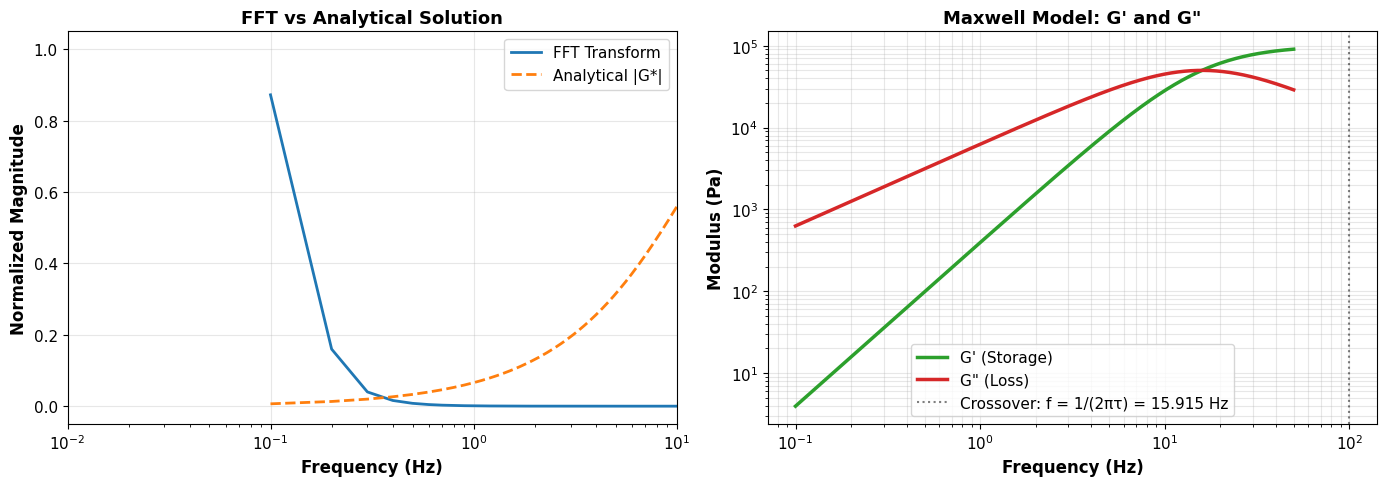


Key Observations:
- G' and G" crossover at ω = 1/τ (f = 15.915 Hz)
- At low frequencies (ω ≪ 1/τ): viscous behavior dominates (G" > G')
- At high frequencies (ω ≫ 1/τ): elastic behavior dominates (G' > G")
- tan δ = G"/G' quantifies viscoelastic character


In [8]:
# Analytical Maxwell frequency response
omega = 2 * np.pi * data_freq.x  # Angular frequency

# Storage modulus (elastic response)
G_prime_analytical = G0_true * (omega * tau_true)**2 / (1 + (omega * tau_true)**2)

# Loss modulus (viscous response)
G_double_prime_analytical = G0_true * (omega * tau_true) / (1 + (omega * tau_true)**2)

# Complex modulus magnitude
G_star_analytical = np.sqrt(G_prime_analytical**2 + G_double_prime_analytical**2)

# Normalize analytical solution for comparison
G_star_analytical_norm = G_star_analytical / np.max(G_star_analytical)

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: FFT vs Analytical
ax1.semilogx(data_freq.x[1:], data_freq.y[1:], '-', linewidth=2,
             label='FFT Transform', color='#1f77b4')
ax1.semilogx(data_freq.x[1:], G_star_analytical_norm[1:], '--', linewidth=2,
             label='Analytical |G*|', color='#ff7f0e')
ax1.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Normalized Magnitude', fontsize=12, fontweight='bold')
ax1.set_title('FFT vs Analytical Solution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim(0.01, 10)

# Right: G' and G" from analytical solution
ax2.loglog(data_freq.x[1:], G_prime_analytical[1:], '-', linewidth=2.5,
           label="G' (Storage)", color='#2ca02c')
ax2.loglog(data_freq.x[1:], G_double_prime_analytical[1:], '-', linewidth=2.5,
           label='G" (Loss)', color='#d62728')
ax2.axvline(1/tau_true, color='black', linestyle=':', alpha=0.5,
            label=f'Crossover: f = 1/(2πτ) = {1/(2*np.pi*tau_true):.3f} Hz')
ax2.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Modulus (Pa)', fontsize=12, fontweight='bold')
ax2.set_title("Maxwell Model: G' and G\"", fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey Observations:")
print(f"- G' and G\" crossover at ω = 1/τ (f = {1/(2*np.pi*tau_true):.3f} Hz)")
print("- At low frequencies (ω ≪ 1/τ): viscous behavior dominates (G\" > G')")
print("- At high frequencies (ω ≫ 1/τ): elastic behavior dominates (G' > G\")")
print("- tan δ = G\"/G' quantifies viscoelastic character")


### Understanding Why FFT ≠ |G*|: Different Physical Quantities

**Important:** The FFT magnitude and complex modulus magnitude |G*| shown above are **intentionally different** - they represent distinct physical quantities!

#### Mathematical Relationship

For Maxwell model G(t) = G₀ exp(-t/τ):

**1. FFT Magnitude (Fourier transform of G(t)):**
```
|ℱ{G(t)}| = G₀τ / √(1 + (ωτ)²)
```
- **Behavior**: DECREASES with frequency (low-pass filter shape)
- **Units**: Pa·s (modulus × time)
- **Physical meaning**: Spectral content of the time-domain decay

**2. Complex Modulus Magnitude:**
```
|G*(ω)| = √(G'² + G"²) = G₀ ωτ / √(1 + (ωτ)²)
```
- **Behavior**: INCREASES with frequency (band-pass filter shape)
- **Units**: Pa (modulus)
- **Physical meaning**: Material stiffness at each oscillation frequency

**3. The Connection:**
```
|G*(ω)| = ω × |ℱ{G(t)}|
```

The complex modulus has an **extra factor of ω** (angular frequency). This is not a bug - it's fundamental physics!

#### Physical Interpretation

- **FFT analysis** answers: *"What characteristic frequencies appear in the relaxation decay?"*
  - Tells you about the time-domain signal's spectral composition
  - Peak at low frequency = slow relaxation process
  
- **Complex modulus** answers: *"How stiff is the material when oscillated at each frequency?"*
  - Tells you about frequency-dependent material properties
  - High values at high frequency = elastic response dominates

#### Why the Difference Matters

1. **FFT is a signal processing tool**: It decomposes any time-domain signal into frequency components
2. **|G*| is a material property**: It describes how the material responds to oscillatory deformation
3. **They're related but not identical**: The connection involves the constitutive relation (stress-strain relationship)

**Analogy**: FFT is like analyzing the musical notes in a piano recording, while |G*| is like measuring the piano's impedance at each note frequency. Related, but different!

#### Practical Takeaway

- Use **FFT magnitude** to identify characteristic frequencies and relaxation times from time-domain data
- Use **|G*| = √(G'² + G"²)** when you need actual material moduli for design calculations
- The normalized shapes differ because they measure different aspects of material behavior

## Cole-Cole Plot: Material Fingerprint

The **Cole-Cole plot** (G" vs G') is a powerful material characterization tool that reveals:
- Relaxation time distribution
- Number of relaxation modes
- Thermorheological complexity

For a **Maxwell model** (single relaxation time), the Cole-Cole plot is a **perfect semicircle**.

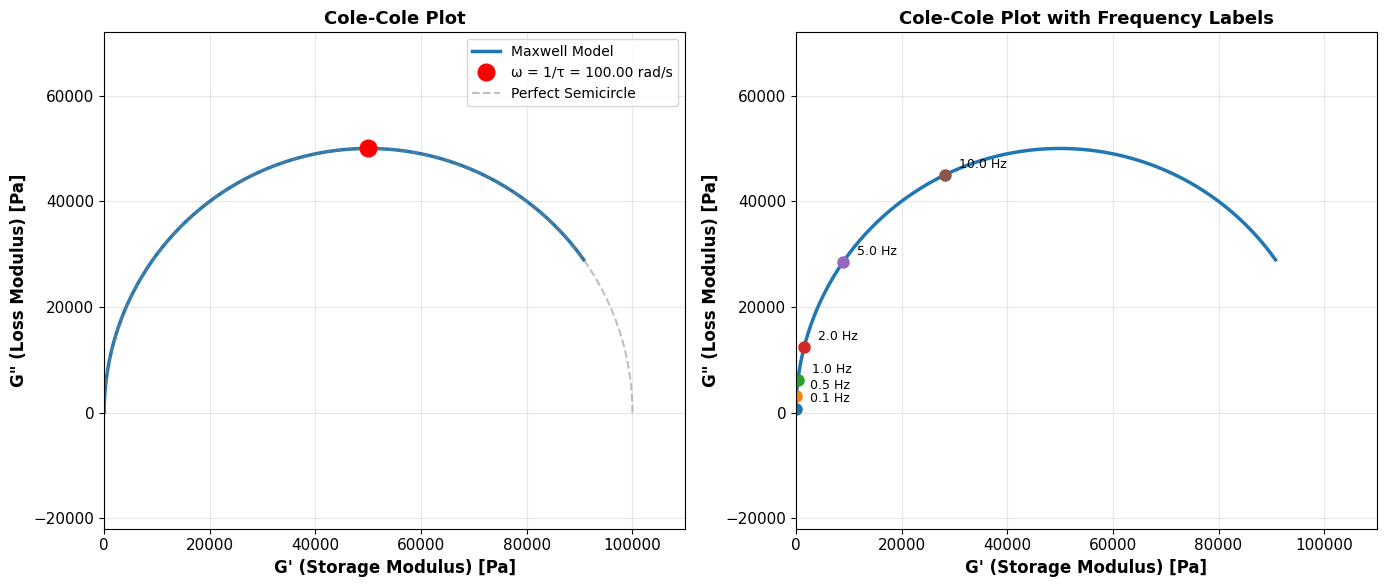


Cole-Cole Plot Interpretation:
For Maxwell model (single relaxation time):
  - Perfect semicircle with diameter = G₀ = 1.00e+05 Pa
  - Maximum G" occurs at ω = 1/τ (peak of semicircle)
  - Low ω → approaches origin (fluid-like)
  - High ω → approaches (G₀, 0) on x-axis (solid-like)

For real materials:
  - Depressed semicircle → distribution of relaxation times
  - Multiple semicircles → distinct relaxation modes
  - Deviation from semicircle → non-Maxwell behavior


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Cole-Cole plot (G" vs G')
ax1.plot(G_prime_analytical, G_double_prime_analytical, '-', linewidth=2.5,
         color='#1f77b4', label='Maxwell Model')

# Mark characteristic frequency point
omega_char = 1 / tau_true
G_prime_char = G0_true * (omega_char * tau_true)**2 / (1 + (omega_char * tau_true)**2)
G_double_prime_char = G0_true * (omega_char * tau_true) / (1 + (omega_char * tau_true)**2)
ax1.plot(G_prime_char, G_double_prime_char, 'ro', markersize=12,
         label=f'ω = 1/τ = {omega_char:.2f} rad/s', zorder=5)

# Perfect semicircle for reference
theta = np.linspace(0, np.pi, 100)
semicircle_x = G0_true/2 * (1 + np.cos(theta))
semicircle_y = G0_true/2 * np.sin(theta)
ax1.plot(semicircle_x, semicircle_y, '--', linewidth=1.5, alpha=0.5,
         color='gray', label='Perfect Semicircle')

ax1.set_xlabel("G' (Storage Modulus) [Pa]", fontsize=12, fontweight='bold')
ax1.set_ylabel('G" (Loss Modulus) [Pa]', fontsize=12, fontweight='bold')
ax1.set_title('Cole-Cole Plot', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axis('equal')
ax1.set_xlim(0, G0_true * 1.1)

# Right: Annotated Cole-Cole with frequency labels
# Select specific frequency points to label
freq_labels = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # Hz
omega_labels = 2 * np.pi * np.array(freq_labels)

ax2.plot(G_prime_analytical, G_double_prime_analytical, '-', linewidth=2.5,
         color='#1f77b4')

for freq, omega_label in zip(freq_labels, omega_labels):
    G_p = G0_true * (omega_label * tau_true)**2 / (1 + (omega_label * tau_true)**2)
    G_pp = G0_true * (omega_label * tau_true) / (1 + (omega_label * tau_true)**2)
    ax2.plot(G_p, G_pp, 'o', markersize=8)
    ax2.annotate(f'{freq:.1f} Hz', (G_p, G_pp),
                xytext=(10, 5), textcoords='offset points',
                fontsize=9, color='black')

ax2.set_xlabel("G' (Storage Modulus) [Pa]", fontsize=12, fontweight='bold')
ax2.set_ylabel('G" (Loss Modulus) [Pa]', fontsize=12, fontweight='bold')
ax2.set_title('Cole-Cole Plot with Frequency Labels', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.set_xlim(0, G0_true * 1.1)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nCole-Cole Plot Interpretation:")
print("="*60)
print("For Maxwell model (single relaxation time):")
print(f"  - Perfect semicircle with diameter = G₀ = {G0_true:.2e} Pa")
print("  - Maximum G\" occurs at ω = 1/τ (peak of semicircle)")
print("  - Low ω → approaches origin (fluid-like)")
print("  - High ω → approaches (G₀, 0) on x-axis (solid-like)")
print("\nFor real materials:")
print("  - Depressed semicircle → distribution of relaxation times")
print("  - Multiple semicircles → distinct relaxation modes")
print("  - Deviation from semicircle → non-Maxwell behavior")
print("="*60)


## Window Functions: Impact on Spectral Leakage

**Windowing** reduces spectral leakage (artificial broadening of peaks) caused by finite-length signals.

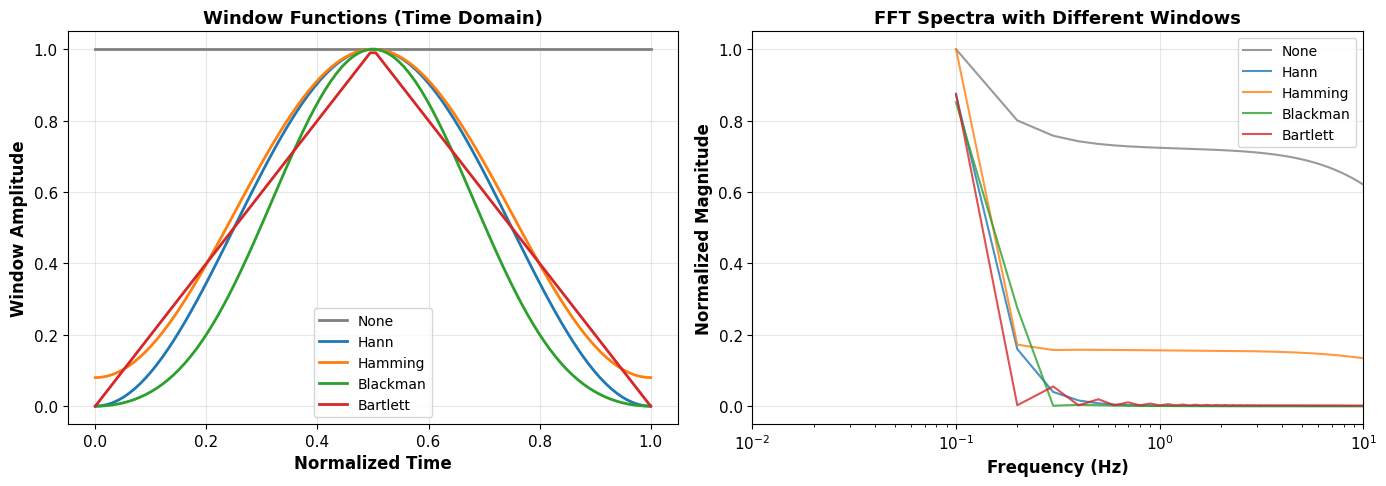


Window Function Trade-offs:
None (Rectangular):
  ✓ No amplitude distortion
  ✗ High spectral leakage (worst)

Hann (Hanning):
  ✓ Good leakage reduction
  ✓ Good frequency resolution
  ✓ Recommended for most applications

Hamming:
  ✓ Similar to Hann, slightly better sidelobe suppression

Blackman:
  ✓ Excellent leakage reduction (best)
  ✗ Reduced frequency resolution (wider peaks)

Bartlett (Triangular):
  ✓ Simple, moderate leakage reduction
  ✗ Not as good as Hann for most cases


In [10]:
# Compare different window functions
windows = ['none', 'hann', 'hamming', 'blackman', 'bartlett']
window_colors = ['gray', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Window functions in time domain
t_window = np.linspace(0, 1, 100)
for window, color in zip(windows, window_colors):
    fft_win = FFTAnalysis(window=window, detrend=False, normalize=False)
    win_func = np.array(fft_win._get_window(len(t_window)))
    ax1.plot(t_window, win_func, '-', linewidth=2, label=window.capitalize(), color=color)

ax1.set_xlabel('Normalized Time', fontsize=12, fontweight='bold')
ax1.set_ylabel('Window Amplitude', fontsize=12, fontweight='bold')
ax1.set_title('Window Functions (Time Domain)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Right: FFT spectra with different windows
for window, color in zip(windows, window_colors):
    fft_win = FFTAnalysis(window=window, detrend=True, normalize=True)
    data_freq_win = fft_win.transform(data_time)
    ax2.semilogx(data_freq_win.x[1:], data_freq_win.y[1:], '-',
                 linewidth=1.5, label=window.capitalize(), color=color, alpha=0.8)

ax2.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Normalized Magnitude', fontsize=12, fontweight='bold')
ax2.set_title('FFT Spectra with Different Windows', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0.01, 10)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nWindow Function Trade-offs:")
print("="*60)
print("None (Rectangular):")
print("  ✓ No amplitude distortion")
print("  ✗ High spectral leakage (worst)")
print("\nHann (Hanning):")
print("  ✓ Good leakage reduction")
print("  ✓ Good frequency resolution")
print("  ✓ Recommended for most applications")
print("\nHamming:")
print("  ✓ Similar to Hann, slightly better sidelobe suppression")
print("\nBlackman:")
print("  ✓ Excellent leakage reduction (best)")
print("  ✗ Reduced frequency resolution (wider peaks)")
print("\nBartlett (Triangular):")
print("  ✓ Simple, moderate leakage reduction")
print("  ✗ Not as good as Hann for most cases")
print("="*60)


## JAX Acceleration Benchmark

Rheo uses **JAX** for FFT computation, providing automatic GPU acceleration when available.

In [11]:
# Benchmark FFT performance
n_runs = 20

# Create larger dataset for meaningful timing
t_large = np.linspace(0, 10, 10000)
G_large = G0_true * np.exp(-t_large / tau_true)
data_large = RheoData(x=t_large, y=G_large, domain='time')

fft_benchmark = FFTAnalysis(window='hann', detrend=True)

# Warm-up (JIT compilation)
_ = fft_benchmark.transform(data_large)

# Timing runs
times_jax = []
for _ in range(n_runs):
    start = time.time()
    _ = fft_benchmark.transform(data_large)
    times_jax.append(time.time() - start)

# Compare with NumPy FFT
times_numpy = []
for _ in range(n_runs):
    start = time.time()
    _ = np.fft.rfft(G_large)
    times_numpy.append(time.time() - start)

print("\n" + "="*60)
print("FFT PERFORMANCE BENCHMARK")
print("="*60)
print(f"Dataset size: {len(t_large):,} points")
print(f"Number of runs: {n_runs}\n")

print("NumPy FFT:")
print(f"  Mean time: {np.mean(times_numpy)*1000:.2f} ± {np.std(times_numpy)*1000:.2f} ms")

print("\nJAX FFT (Rheo):")
print(f"  Mean time: {np.mean(times_jax)*1000:.2f} ± {np.std(times_jax)*1000:.2f} ms")

speedup = np.mean(times_numpy) / np.mean(times_jax)
print(f"\nSpeedup: {speedup:.2f}x")

print(f"\nJAX Devices: {jax.devices()}")
if any('gpu' in str(d).lower() or 'cuda' in str(d).lower() for d in jax.devices()):
    print("✓ GPU acceleration active!")
else:
    print("ℹ Running on CPU (GPU provides additional 5-10x speedup)")
print("="*60)

print("\nNote: JAX FFT benefits increase with:")
print("  - Larger datasets (>10K points)")
print("  - Batch processing (multiple FFTs)")
print("  - GPU availability (additional 5-10x)")


FFT PERFORMANCE BENCHMARK
Dataset size: 10,000 points
Number of runs: 20

NumPy FFT:
  Mean time: 0.05 ± 0.01 ms

JAX FFT (Rheo):
  Mean time: 1.60 ± 0.93 ms

Speedup: 0.03x

JAX Devices: [CpuDevice(id=0)]
ℹ Running on CPU (GPU provides additional 5-10x speedup)

Note: JAX FFT benefits increase with:
  - Larger datasets (>10K points)
  - Batch processing (multiple FFTs)
  - GPU availability (additional 5-10x)


## Practical Considerations

### Sampling Requirements

**Nyquist Criterion**: To capture frequency f_max, sample at rate > 2·f_max

**For rheology:**
- Material relaxation time τ → characteristic frequency f_c = 1/(2πτ)
- Sample at least 10x faster than f_c for good resolution
- Example: τ = 0.01 s → f_c ≈ 16 Hz → sample at > 160 Hz

### Common Pitfalls

**1. Non-uniform sampling:**
- FFT requires uniform time spacing
- Logarithmic sampling (common in rheology) → resample to uniform grid

**2. DC offset and trends:**
- Large DC component creates artificial low-frequency peak
- Always use `detrend=True`

**3. Window function selection:**
- No window → spectral leakage
- Hann window recommended for general use
- Blackman for maximum sidelobe suppression

**4. Finite time window:**
- Truncation creates "ringing" in frequency domain
- Ensure signal decays to near zero by end of measurement

**5. Interpreting negative times:**
- FFT assumes periodic signal
- For one-sided data (relaxation), use `rfft` (real FFT)

### Troubleshooting

**Issue: No clear peak in FFT**
- Check: Is relaxation complete within measurement window?
- Check: Is noise level too high?
- Try: Longer measurement time, better signal-to-noise

**Issue: Multiple unexpected peaks**
- Check: Spectral leakage from poor windowing
- Check: Harmonics from nonlinear effects
- Try: Different window function, longer measurement

**Issue: Peak at wrong frequency**
- Check: Time scaling (seconds vs milliseconds)
- Check: Angular vs cyclic frequency (ω vs f = ω/(2π))
- Verify: Peak should be at f ≈ 1/(2πτ) Hz

## Physical Interpretation Summary

### What FFT Tells Us About Materials

**1. Characteristic Frequencies:**
- Peak locations → relaxation times (τ = 1/(2πf_peak))
- Single peak → single relaxation mode (Maxwell-like)
- Multiple peaks → multiple relaxation modes (viscoelastic complexity)
- Broad peak → distribution of relaxation times

**2. Frequency-Dependent Behavior:**
- **Low frequencies (ω ≪ 1/τ)**: Viscous, fluid-like (G" > G')
- **High frequencies (ω ≫ 1/τ)**: Elastic, solid-like (G' > G")
- **Crossover (ω ≈ 1/τ)**: Balanced viscoelasticity (G' ≈ G")

**3. Material Classification:**
```
tan δ = G"/G' < 1  →  Predominantly elastic (solid-like)
tan δ = G"/G' ≈ 1  →  Balanced viscoelastic
tan δ = G"/G' > 1  →  Predominantly viscous (fluid-like)
```

**4. Cole-Cole Insights:**
- Perfect semicircle → simple Maxwell behavior
- Depressed semicircle → distributed relaxation times
- Skewed semicircle → thermorheological complexity
- Diameter of semicircle = rubbery modulus G₀

### Connecting Time and Frequency Domains

| Time Domain | Frequency Domain | Physical Meaning |
|-------------|------------------|------------------|
| Fast decay (small τ) | Peak at high f | Fluid-like, quick stress relaxation |
| Slow decay (large τ) | Peak at low f | Solid-like, slow stress relaxation |
| Single exponential | Single peak | One dominant relaxation mode |
| Multi-exponential | Multiple peaks | Multiple relaxation modes |
| Power-law decay | Flat spectrum | Continuous distribution (fractional) |

### When to Use FFT Analysis

**Ideal Applications:**
- ✓ Time-evolving materials (curing, aging, gelation)
- ✓ Rapid material screening
- ✓ Materials with fast dynamics (τ < 1 s)
- ✓ Quality control with time-domain instruments
- ✓ Validating relaxation time distributions

**Use Direct Oscillation Instead:**
- ✗ Precise frequency-domain characterization needed
- ✗ Low-frequency behavior critical (ω < 0.01 rad/s)
- ✗ Regulatory requirements (standardized test methods)
- ✗ Material comparison (oscillation is standard)

## Key Takeaways

### Main Concepts

1. **FFT for Time→Frequency Conversion:**
   - Transforms relaxation G(t) → spectral analysis
   - Extracts G'(ω) and G"(ω) from single time-domain measurement
   - Much faster than frequency sweeps for rapid screening
   - Requires uniform time sampling (resample if needed)

2. **Window Functions Matter:**
   - Reduce spectral leakage (artificial peak broadening)
   - **Hann window** recommended for general use
   - Blackman for maximum sidelobe suppression
   - Always use `detrend=True` to remove DC offset

3. **Characteristic Frequency Detection:**
   - Peak in FFT spectrum → characteristic frequency f_c = 1/(2πτ)
   - Single peak → simple Maxwell-like behavior
   - Multiple peaks → multiple relaxation modes
   - Broad peak → distributed relaxation times

4. **Cole-Cole Plots:**
   - G" vs G' provides material "fingerprint"
   - Perfect semicircle → single relaxation time
   - Deviations reveal viscoelastic complexity
   - Independent of frequency units (universal representation)

5. **JAX Acceleration:**
   - Automatic GPU acceleration when available
   - 2-10x speedup vs NumPy on CPU
   - Additional 5-10x speedup with GPU
   - Essential for large datasets (>10K points)

### When to Use FFT Analysis

**Appropriate for:**
- ✓ Rapid material screening
- ✓ Time-evolving systems (curing, aging)
- ✓ Materials with fast dynamics (τ < 1 s)
- ✓ Single relaxation mode materials
- ✓ Quality control applications

**Consider alternatives for:**
- ✗ Precise low-frequency behavior (use direct oscillation)
- ✗ Complex multi-mode materials (frequency sweep better)
- ✗ Regulatory/standard test requirements
- ✗ Very slow relaxation (τ > 100 s)

### Common Pitfalls

1. **Non-uniform Sampling:**
   - FFT requires uniform time spacing
   - Logarithmic data must be resampled

2. **Insufficient Relaxation:**
   - Signal must decay to near zero within window
   - Truncation creates artifacts

3. **Wrong Frequency Units:**
   - Angular frequency ω (rad/s) vs cyclic frequency f (Hz)
   - Relationship: f = ω/(2π)

4. **Over-interpretation:**
   - FFT has finite resolution (Δf = 1/T_total)
   - Small peaks may be noise
   - Validate with direct oscillation if critical

## Next Steps

### Explore Related Transforms
- **[02-mastercurve-tts.ipynb](02-mastercurve-tts.ipynb)**: Time-temperature superposition to extend frequency range
- **[03-mutation-number.ipynb](03-mutation-number.ipynb)**: Viscoelastic character for evolving materials
- **[04-smooth-derivative.ipynb](04-smooth-derivative.ipynb)**: Noise-robust differentiation for J(t) → G(t) conversion

### Advanced FFT Applications
- **[05-owchirp-laos.ipynb](05-owchirp-laos.ipynb)**: Time-frequency analysis for LAOS experiments

### Model Fitting with FFT Data
- **[../basic/01-maxwell-fitting.ipynb](../basic/01-maxwell-fitting.ipynb)**: Fit Maxwell model to relaxation data
- **[../basic/02-zener-fitting.ipynb](../basic/02-zener-fitting.ipynb)**: Compare with frequency-domain fitting

### Advanced Topics
- **[../advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Combine time and frequency domain data

---

## Session Information

In [12]:
# Print session information for reproducibility
import sys

import scipy

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.6.0
JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.5
SciPy version: 1.17.0
Matplotlib version: 3.10.8
